## import modules and define a function to draw an NBA court

In [1]:
# import modules and libraries and set parameters 

import json
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Arc, Rectangle
%matplotlib inline

import nba_api as nba
from nba_api.stats.static import players
from nba_api.stats.static import teams 
from nba_api.stats.endpoints import shotchartdetail

# just to get team colors
from nba_py import constants

from numpy import sin, cos, tan, sqrt, pi, log, log10, linspace
import pandas as pd
import requests


# court dimensions
yRim = 6 # rim center location (ft)
yCourt = 47*2 # court length (ft)
xCourt = 25*2 # court width (ft)
r3PT = 23.75 # radius of the 3 point arc from the rim (ft)
x3PT = 22 # horizontal distance of the corner 3 point line from the rim (ft)
yCorner = sqrt(23.75**2 - x3PT**2) + yRim # vertical distance of the intersection of the arc and 3 point line from the rim (ft)
xPaint = 8 # horizontal distance of the paint from the rim (ft)
yPaint = 13 # vertical distance of the paint from the rim (ft)


# plot colors (Vega 10 palette) and properties 
blue = "#1f77b4"
orange = "#ff7f0e"
green =  "#2ca02c"
red = "#d62728"
purple = "#9467bd"
brown = "#8c564b"
pink = "#e377c2"
gray = "#7f7f7f"
cyan = "#17becf"
black = "#000000"

LW = 5                 # line width
FS = 30                # font size
FN = 'times new roman' # font name

font = {'family':'serif', 'size':FS}
plt.rc('text', usetex=True) 
plt.rc('font', **font)

ModuleNotFoundError: No module named 'nba_api'

In [40]:
# define a function to draw a 2D NBA courts 

# draws a 2D NBA basketball half-court
def nba_2dhalfcourt(ax, scale, linecolor, keycolor, alpha, linewidth):
    '''
    Draws a 2D NBA basketball half-court
    inputs:
        scale, ax, color, keycolor, alpha, linewidth
    outputs:
        ax
    ''' 
    
    # bounds
    box = Rectangle((-25/scale, 0/scale), 50/scale, 47/scale, facecolor='none', edgecolor=linecolor, linewidth=linewidth, angle = 0)
    ax.add_artist(box)

    # sidelines: in case the box does not show them
    ax.plot([-25/scale, -25/scale], [0/scale, 47/scale], linewidth=linewidth, color=linecolor)
    ax.plot([25/scale, 25/scale], [0/scale, 47/scale], linewidth=linewidth, color=linecolor)
    
    # 3PT Arc
    x = linspace(-22, 22, 100)
    y = sqrt(23.75**2 - x**2) + 6
    ax.plot(x/scale, y/scale, linewidth = linewidth, color = linecolor)
    
    # corner 3PT lines
    ax.plot([x[0]/scale, x[0]/scale], [0/scale, y[0]/scale], linewidth=linewidth, color=linecolor)
    ax.plot([x[-1]/scale, x[-1]/scale], [0/scale, y[0]/scale], linewidth=linewidth, color=linecolor)
  

    # mid court semicircle
    x = linspace(-6, 6, 100)/scale
    y = -sqrt((6/scale)**2 - x**2)+47/scale
    ax. plot(x,y, linewidth = linewidth, color = linecolor)
    
    # key
    box = Rectangle((-8/scale, 0/scale), 16/scale, 19/scale, facecolor=keycolor, alpha =  alpha, edgecolor=linecolor, linewidth=linewidth, angle = 0)
    ax.add_artist(box)
    
    # top key 
    x = linspace(-6, 6, 100)
    y = sqrt(6**2 - x**2) + 19
    ax.plot(x/scale, y/scale, linewidth = linewidth, color = linecolor) 
    
    # bottom  key
    x = linspace(-6, 6, 100)
    y = -sqrt(6**2 - x**2) + 19
    ax.plot(x/scale, y/scale, '--', linewidth = linewidth, color = linecolor)

    # restricetd area semicircle
    x = linspace(-4, 4, 100)
    y = sqrt(4**2 - x**2) + 6
    ax.plot(x/scale, y/scale, linewidth = linewidth, color = linecolor)
        

    # Rim
    ax.add_artist(Circle((0/scale, 6/scale), 1.5/scale, facecolor='none', edgecolor=linecolor, linewidth=linewidth))
    
    # Backboard
    ax.plot([-3/scale, 3/scale], [4/scale, 4/scale], linewidth=linewidth, color=linecolor)

    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])

    return ax


## get player information and collect data 

In [3]:
# find player_ID and team_ID of the players requested by the user 

# get a list of all players
player_dict = players.get_players()

# get a list of all teams
team_dict = teams.get_teams()

# initiate the basketball player dictionary
BP = {}
BP['fullName'] = {}
BP['playerID'] = {}
BP['team'] = {}
BP['teamName'] = {}
BP['teamID'] = {}
BP['colors'] = {} # team primary and secondary colors
BP['season'] = {}
BP['FGA'] = {} # all shot attempts
BP['PTS'] = {} # all made shots
BP['C3A'] = {} # corner 3 point shot attempts
BP['C3M'] = {} # made corner 3 point shots
BP['A3A'] = {} # beyond arc 3 point attempst
BP['A3M'] = {} # made beyond arc 3 point shots
BP['P2A'] = {} # in the paint shot attempts
BP['P2M'] = {} # made in the paint shots
BP['O2A'] = {} # outside the paint 2 point shot attempts
BP['O2M'] = {} # made outside the paint 2 point shots
    

print('\n enter number of players to compare')
n = -1
while  n < 1:
    if n is not -1:
        print('number is not valid')
    n = int(input('number of players to compare: '))

for ii in range(n):
    # get player full name and find his ID 
    print('\n enter player '+ str(ii+1)+  ' full name (e.g LeBron James)')
    name = 'AA'
    while name not in [player['full_name'] for player in player_dict]: 
        if name is not 'AA':
            print('player ', str(ii+1), ' was not found')
        name = input('player ' + str(ii+1)+ ': ')      
        BP['fullName'][ii] = name      
    BP['playerID'][ii] = [player for player in player_dict if player['full_name'] == name][0]['id']
    
    # get team name and find its id
    print('\n enter player '+ str(ii+1)+  ' team (abbreviation)')
    BP['team'][ii] = 'AA'
    while BP['team'][ii].upper() not in [team['abbreviation'] for team in team_dict]: 
        if BP['team'][ii] is not 'AA':
            print('player '+ str(ii+1) + ' team was not found')
        BP['team'][ii] = input('player ' + str(ii+1)+ ': ').upper()            
    BP['teamName'][ii] = [team for team in team_dict if team['abbreviation'] == BP['team'][ii]][0]['full_name']
    BP['teamID'][ii] =[team for team in team_dict if team['abbreviation'] == BP['team'][ii]][0]['id']
    
    
    BP['colors'][ii] = {}
    for jj in range(2):
        BP['colors'][ii][jj] = '#' + constants.TEAMS[BP['team'][ii]]['colors'][jj]
    
    # get a desired season
    print('\n enter player '+ str(ii+1)+  ' season (e.g. 2015-16)')
    BP['season'][ii] = input('player ' + str(ii+1)+ ' season: ')


 enter number of players to compare
number of players to compare: 3 

 enter player 1 full name (e.g LeBron James)
player 1: Stephen Curry

 enter player 1 team (abbreviation)
player 1: gsw

 enter player 1 season (e.g. 2015-16)
player 1 season: 2015-16

 enter player 2 full name (e.g LeBron James)
player 2: Russell Westbrook

 enter player 2 team (abbreviation)
player 2: okc

 enter player 2 season (e.g. 2015-16)
player 2 season: 2016-17

 enter player 3 full name (e.g LeBron James)
player 3: James Harden

 enter player 3 team (abbreviation)
player 3: hou

 enter player 3 season (e.g. 2015-16)
player 3 season: 2017-18


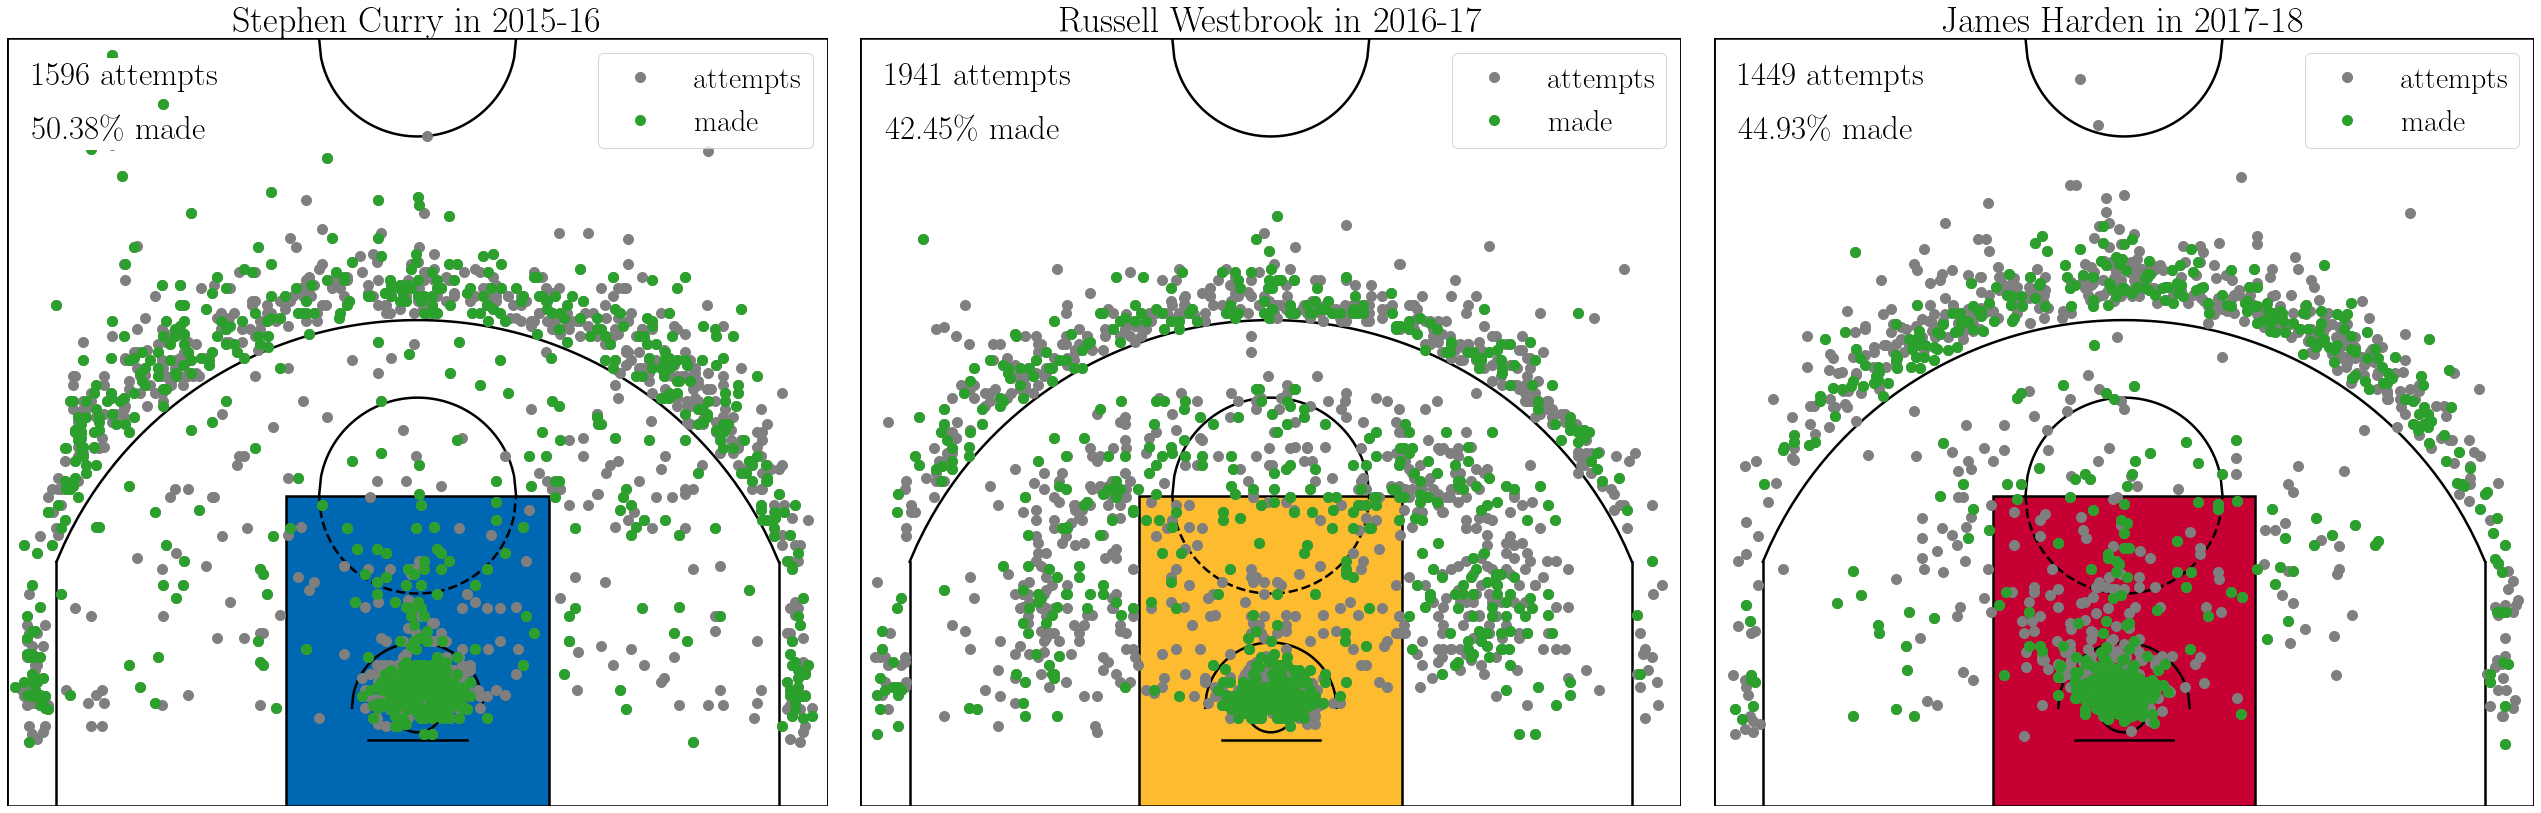

In [41]:
# get shot chart details of the basketball players (all shot attempts during regular season) 

# I used the following notebook as a guideline to create the JSON request and convert the results into a dataframe:
# https://github.com/n-venkatesan/medium-articles/blob/master/nba_shotchart.ipynb

# data is reported in 1/10 scale
scale = 1/10 

for ii in range(n):   
    # Create JSON request
    shot_json = shotchartdetail.ShotChartDetail(
        team_id = BP['teamID'][ii], 
        player_id = BP['playerID'][ii], 
        #context_measure_simple = 'PTS', # shots made
        context_measure_simple = 'FGA', # shots attempted
        season_nullable = BP['season'][ii], 
        season_type_all_star = 'Regular Season')

    # Load data into a Python dictionary and get the relevant results
    shots = json.loads(shot_json.get_json())
    results = shots['resultSets'][0]
    headers = results['headers']
    rows = results['rowSet']

    # Create pandas DataFrame of all attempted shots
    BP['FGA'][ii] = pd.DataFrame(rows)
    BP['FGA'][ii].columns = headers
    
    # Create pandas DataFrame of all made shots
    BP['PTS'][ii] = BP['FGA'][ii][BP['FGA'][ii]['SHOT_MADE_FLAG'] == 1]
    
fig = plt.figure(figsize=(12*n, 12))
for ii in range(n):
    
    FGA = BP['FGA'][ii]
    PTS = BP['PTS'][ii]
    
    ax = fig.add_subplot(1, n, ii+1)
    ax = nba_2dhalfcourt(scale=1/10, ax=ax, linecolor=black, keycolor=BP['colors'][ii][0], alpha = 1, linewidth = LW/2)
    ax.plot(FGA['LOC_X'], FGA['LOC_Y'] + yRim/scale, 'o', markersize = 10, color = gray, label='attempts')
    ax.plot(PTS['LOC_X'], PTS['LOC_Y'] + yRim/scale, 'o', markersize = 10, color = green, label='made')
    ax.annotate(str(len(FGA)) + ' attempts', (0.03, 0.94), xycoords='axes fraction', fontsize = 1.1*FS, backgroundcolor='white', horizontalalignment = 'left')
    ax.annotate(str(round(len(PTS)/len(FGA)*100,2)) + '\% made', (0.03, 0.87), xycoords='axes fraction', fontsize = 1.1*FS, backgroundcolor='white', horizontalalignment = 'left')
    ax.legend(loc=1)
    ax.set_title(BP['fullName'][ii] + ' in ' + BP['season'][ii])
    ax.set_ylim([0, 0.5*yCourt/scale])
    ax.set_xlim([-0.5*xCourt/scale, 0.5*xCourt/scale])
    ax.axis('off')
    plt.tight_layout()
   

## breakdown shots into the following categories: 

-3 pointers beyond the arc

-corner 3s

-points inside the paint

-2 pointers outside the paint

In [5]:
# breakdown shots into 4 categories 

for ii in range(n):
    
    #### all shots ###################################################
    FGA = BP['FGA'][ii]
    ##################################################################
    
    #### 3 point shots beyond the arc ################################
    A3A = FGA[(FGA['SHOT_TYPE'] == '3PT Field Goal') &
              (FGA['LOC_Y'] + yRim/scale > yCorner/scale)]
    A3M = A3A[A3A['SHOT_MADE_FLAG'] == 1]
    
    BP['A3A'][ii] = A3A
    BP['A3M'][ii] = A3M
    ###################################################################
    
    #### corner 3 point shots #########################################
    C3A = FGA[(FGA['SHOT_TYPE'] == '3PT Field Goal') &
              (FGA['LOC_Y'] + yRim/scale <= yCorner/scale)]
    C3M = C3A[C3A['SHOT_MADE_FLAG'] == 1]
    
    BP['C3A'][ii] = C3A
    BP['C3M'][ii] = C3M
    ###################################################################
    
    #### 2 point shosts inside the paint  #############################
    P2A = FGA[(abs(FGA['LOC_Y']) <= yPaint/scale) & 
              (abs(FGA['LOC_X']) <= xPaint/scale)]
    P2M = P2A[P2A['SHOT_MADE_FLAG'] == 1]
    
    BP['P2A'][ii] = P2A
    BP['P2M'][ii] = P2M
    ###################################################################
    
    #### 2 point shots outside the paint ##### ########################
    O2A = FGA[(FGA['SHOT_TYPE'] == '2PT Field Goal') & 
              ((abs(FGA['LOC_Y']) > yPaint/scale) | 
              (abs(FGA['LOC_X']) > xPaint/scale))]
    O2M = O2A[O2A['SHOT_MADE_FLAG'] == 1]
            
    BP['O2A'][ii] = O2A
    BP['O2M'][ii] = O2M
    ###################################################################
     

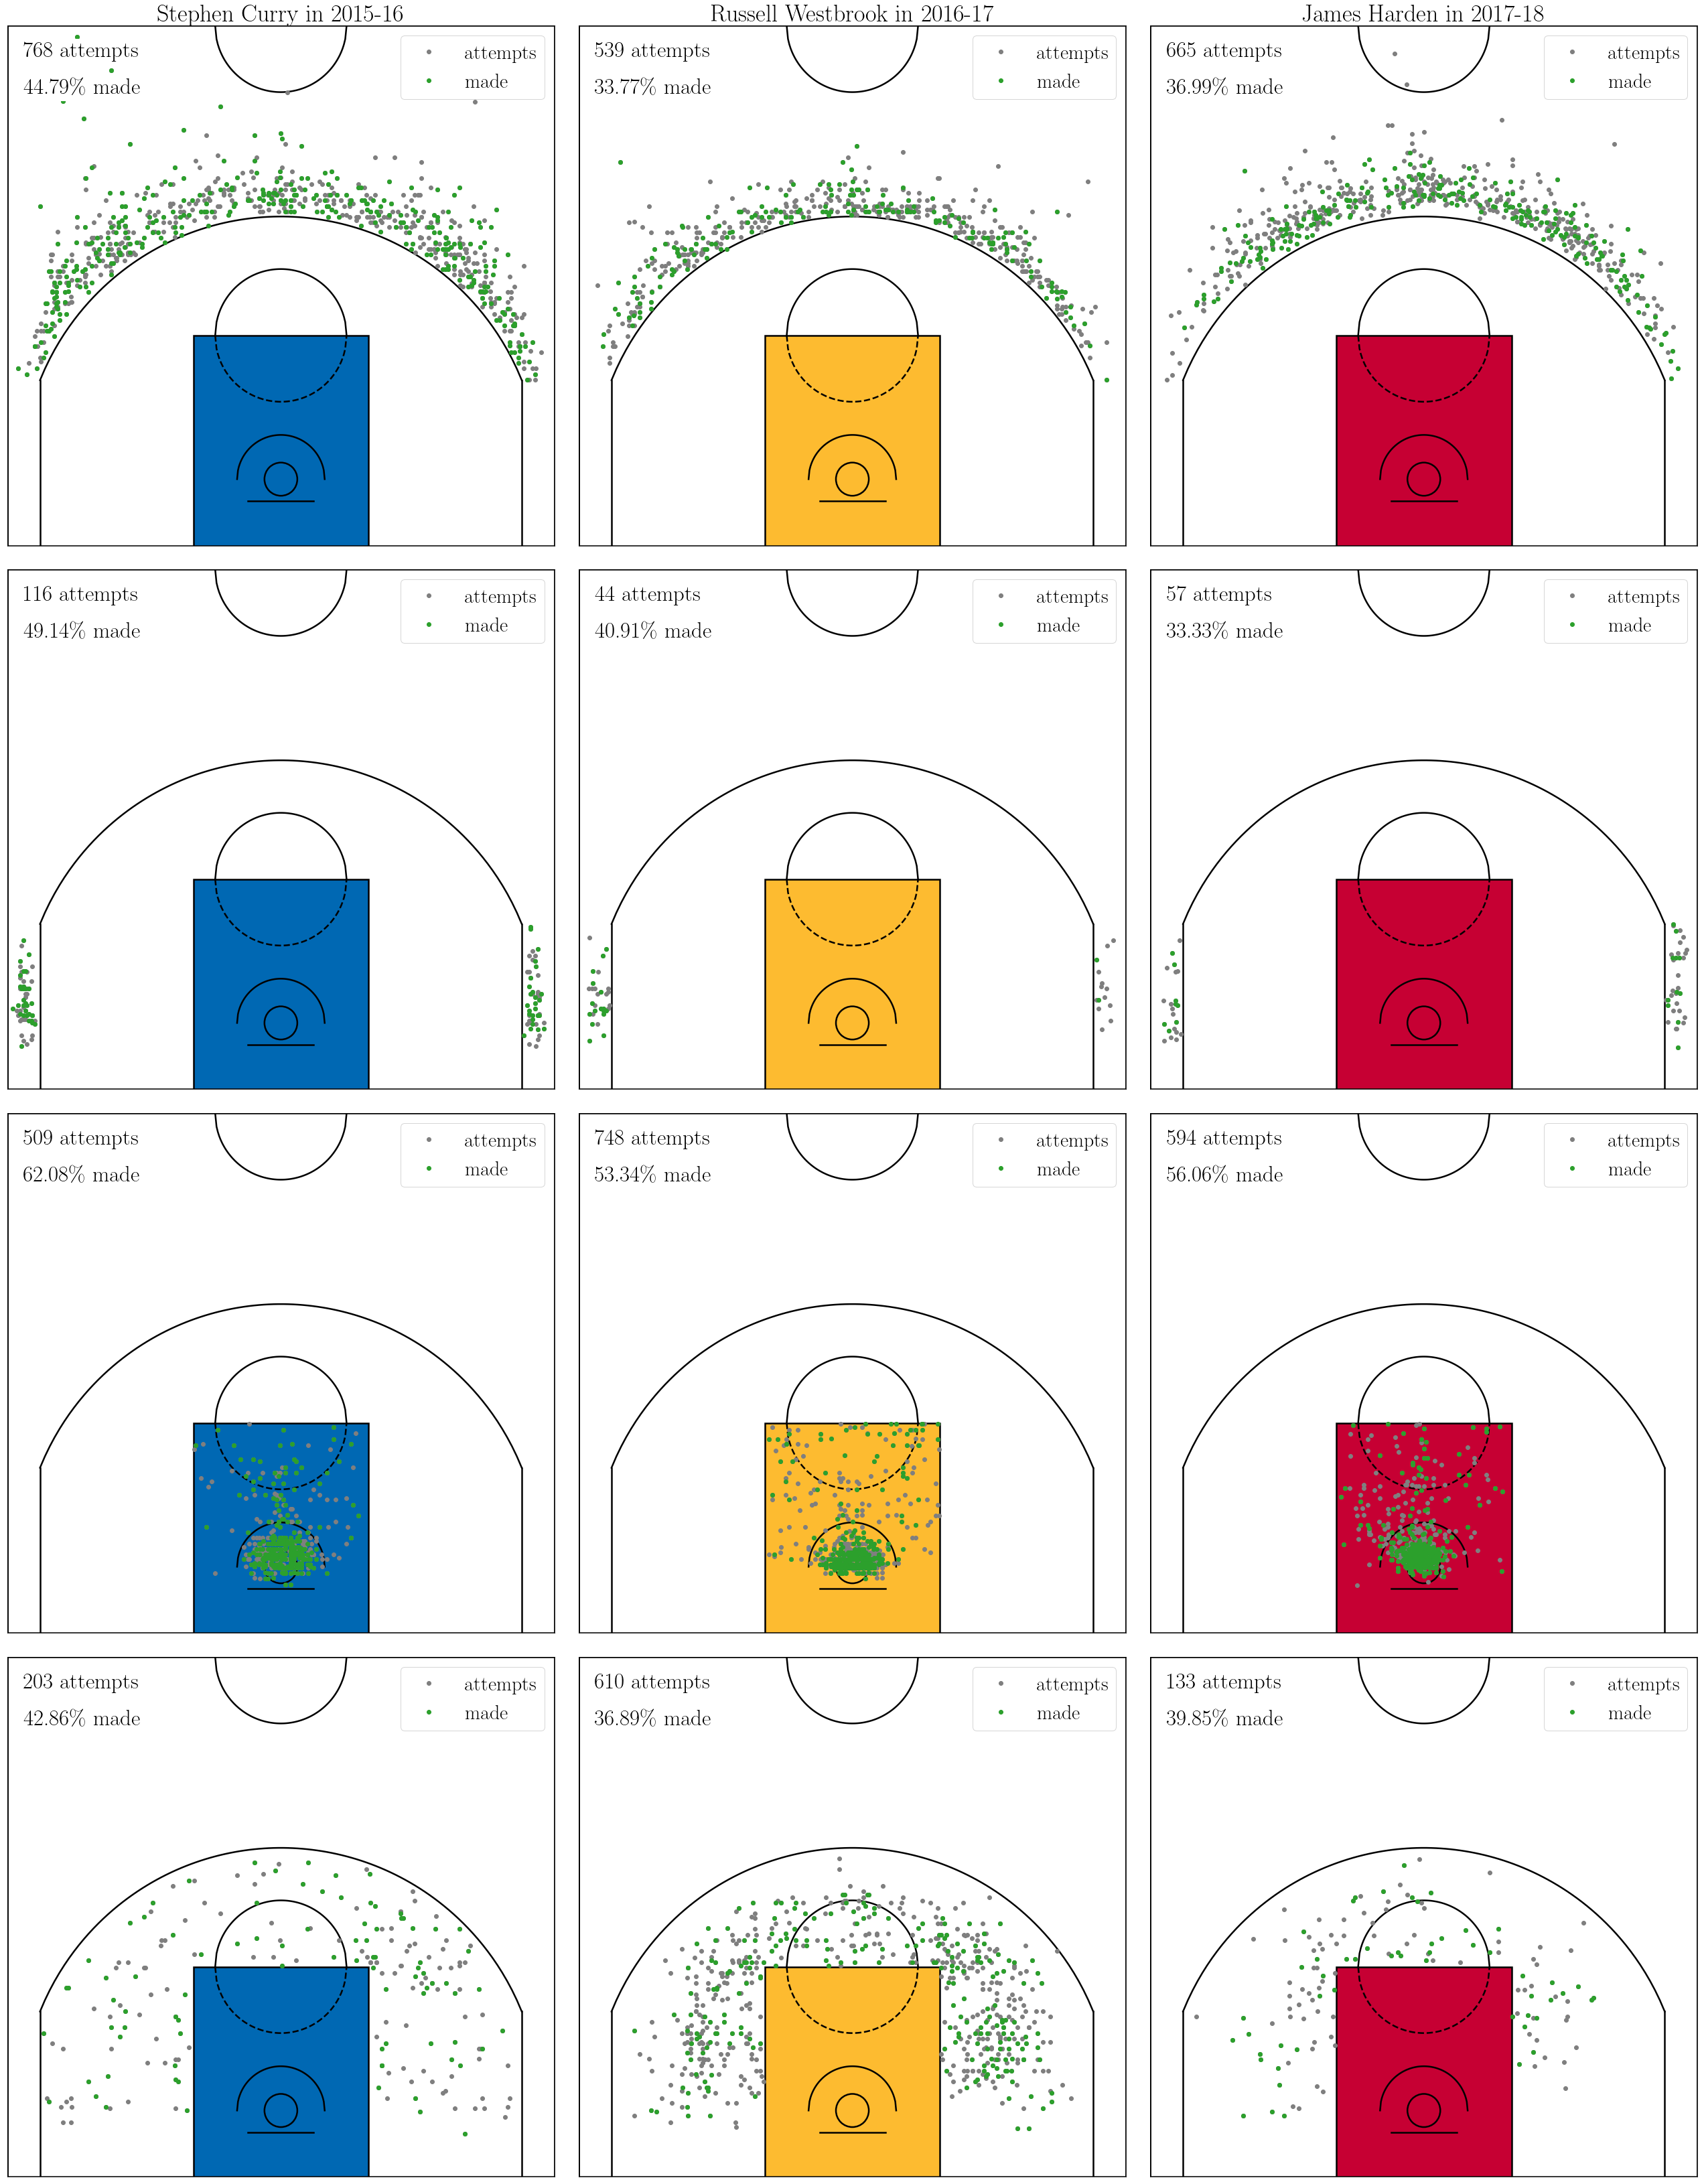

In [42]:
# plot shot categories 

attempts = ['A3A', 'C3A', 'P2A', 'O2A']
mades = ['A3M', 'C3M', 'P2M', 'O2M']
m = len(attempts)

fig = plt.figure(figsize=(12*n, 11.5*m))
for ii in range(n):
    for jj in range(m):   
        attempt = BP[attempts[jj]][ii]
        made = BP[mades[jj]][ii] 

        ax = fig.add_subplot(m, n, n*jj +(ii+1))
        ax = nba_2dhalfcourt(scale=1/10, ax=ax, linecolor=black, keycolor=BP['colors'][ii][0], alpha = 1, linewidth = LW/2)
        ax.plot(attempt['LOC_X'], attempt['LOC_Y'] + yRim/scale, 'o', color=gray, label='attempts')
        ax.plot(made['LOC_X'], made['LOC_Y'] + yRim/scale, 'o', color=green, label = 'made')
        ax.annotate(str(len(attempt)) + ' attempts', (0.03, 0.94), xycoords='axes fraction', fontsize = 1.1*FS, backgroundcolor='white', horizontalalignment = 'left')
        ax.annotate(str(round(len(made)/len(attempt)*100,2)) + '\% made', (0.03, 0.87), xycoords='axes fraction', fontsize = 1.1*FS, backgroundcolor='white', horizontalalignment = 'left')
        ax.legend(loc=1)
        if jj == 0:
            ax.set_title(BP['fullName'][ii] + ' in ' + BP['season'][ii])
        ax.set_ylim([0, 0.5*yCourt/scale])
        ax.set_xlim([-0.5*xCourt/scale, 0.5*xCourt/scale])    
        plt.tight_layout()
plt.savefig('nba_comparison.pdf')
